# Import libraries

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


import random
import torch
from torch import nn

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Reading preprocessed dataset

In [2]:
data = pd.read_csv('preprocessed_data.csv')

In [3]:
data.head()

,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Attrition
0,0.785714,0.5,0.178571,0.25,0.0,0.00,0.637546,0.111111,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.309524,1.0,0.321429,0.00,0.0,0.00,0.167457,0.000000,0.857143,0.333333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
2,0.333333,1.0,0.571429,0.75,1.0,0.75,0.964666,0.111111,0.285714,1.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,0.476190,0.0,0.035714,1.00,1.0,0.50,0.385045,0.333333,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.333333,0.5,0.321429,0.00,1.0,0.00,0.070195,0.444444,0.071429,0.666667,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0


### Implementation of `DataSet` object for `DataLoader` 

In [4]:
from torch.utils.data import DataLoader, Dataset

In [5]:
class DataSet(Dataset):
    def __init__(self, X, y=None, mode='train'):
        self.X = X
        self.y = y
        self.mode=mode
        
    def __len__(self,):
        return len(self.X)
    
    def __getitem__(self, idx):
        xi = torch.tensor(self.X[idx]).float()
        if self.mode!='test':
            yi = torch.tensor(self.y[idx]).long()
            return xi, yi
        else:
            return xi

### Splitting data and defining generators

In [6]:
X = data.drop('Attrition', 1).to_numpy()
y = data['Attrition'].to_numpy()

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from torchvision.transforms import ToTensor

In [10]:
trainset = DataSet(X_train, y_train, mode='train')
valset = DataSet(X_test, y_test, mode='val')

traingen = DataLoader(trainset, batch_size=32, shuffle=False)
valgen = DataLoader(valset, batch_size=32, shuffle=False)

### Model Architectures

In [11]:
from collections import OrderedDict

class FCNN_relu(nn.Module):
    def __init__(self, num_blocks=0):
        super().__init__()
        self.base=nn.Identity() if num_blocks==0 else self.compile(num_blocks)
        self.fc=nn.Linear(41, 1) if num_blocks==0 else nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.base(x)
        return self.fc(x)
    
    def block(self, b, num_blocks):
        block = nn.Sequential()
        if b==0:
            block.add_module('linear'+str(b), nn.Linear(41, 100))
            block.add_module('bn'+str(b), nn.BatchNorm1d(100))
            block.add_module('relu'+str(b), nn.ReLU())
            
        elif b==(num_blocks-1):
            block.add_module('drop'+str(b), nn.Dropout(0.2))
            block.add_module('linear'+str(b), nn.Linear(100, 100))
            block.add_module('bn'+str(b), nn.BatchNorm1d(100))
            block.add_module('relu'+str(b), nn.ReLU())
        else:
            block.add_module('linear'+str(b), nn.Linear(100, 100))
            block.add_module('bn'+str(b), nn.BatchNorm1d(100))
            block.add_module('relu'+str(b), nn.ReLU())
        return block
        
    def compile(self, num_blocks):
        model = nn.Sequential()
        for b in range(num_blocks):
            model.add_module('block'+str(b), self.block(b, num_blocks))
        return model

In [12]:
from collections import OrderedDict

class FCNN_lrelu(nn.Module):
    def __init__(self, num_blocks=0):
        super().__init__()
        self.base=nn.Identity() if num_blocks==0 else self.compile(num_blocks)
        self.fc=nn.Linear(41, 1) if num_blocks==0 else nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.base(x)
        return self.fc(x)
    
    def block(self, b, num_blocks):
        block = nn.Sequential()
        if b==0:
            block.add_module('linear'+str(b), nn.Linear(41, 100))
            block.add_module('bn'+str(b), nn.BatchNorm1d(100))
            block.add_module('lrelu'+str(b), nn.LeakyReLU(0.2))
            
        elif b==(num_blocks-1):
            block.add_module('drop'+str(b), nn.Dropout(0.2))
            block.add_module('linear'+str(b), nn.Linear(100, 100))
            block.add_module('bn'+str(b), nn.BatchNorm1d(100))
            block.add_module('lrelu'+str(b), nn.LeakyReLU(0.2))
        else:
            block.add_module('linear'+str(b), nn.Linear(100, 100))
            block.add_module('bn'+str(b), nn.BatchNorm1d(100))
            block.add_module('lrelu'+str(b), nn.LeakyReLU(0.2))
        return block
        
    def compile(self, num_blocks):
        model = nn.Sequential()
        for b in range(num_blocks):
            model.add_module('block'+str(b), self.block(b, num_blocks))
        return model

In [13]:
from collections import OrderedDict

class FCNN_tnh(nn.Module):
    def __init__(self, num_blocks=0):
        super().__init__()
        self.base=nn.Identity() if num_blocks==0 else self.compile(num_blocks)
        self.fc=nn.Linear(41, 1) if num_blocks==0 else nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.base(x)
        return self.fc(x)
    
    def block(self, b, num_blocks):
        block = nn.Sequential()
        if b==0:
            block.add_module('linear'+str(b), nn.Linear(41, 100))
            block.add_module('bn'+str(b), nn.BatchNorm1d(100))
            block.add_module('tnh'+str(b), nn.Tanh())
            
        elif b==(num_blocks-1):
            block.add_module('drop'+str(b), nn.Dropout(0.2))
            block.add_module('linear'+str(b), nn.Linear(100, 100))
            block.add_module('bn'+str(b), nn.BatchNorm1d(100))
            block.add_module('tnh'+str(b), nn.Tanh())
        else:
            block.add_module('linear'+str(b), nn.Linear(100, 100))
            block.add_module('bn'+str(b), nn.BatchNorm1d(100))
            block.add_module('tnh'+str(b), nn.Tanh())
        return block
        
    def compile(self, num_blocks):
        model = nn.Sequential()
        for b in range(num_blocks):
            model.add_module('block'+str(b), self.block(b, num_blocks))
        return model

In [14]:
def train(model, criterion, optimizer, scheduler, metric, tgen, vgen, epochs=10, device='cuda:0'):
    cache={'loss':[], 'acc': [], 'v_loss':[], 'v_acc':[], 'epoch':[]}
    for epoch in range(1, epochs+1):
        log = f'::: Epoch {epoch}/{epochs} :::'
        model.train()
        r_loss, r_acc = 0, 0
        for x, y in tgen:
            x, y = x.to(device), y.to(device)
            y_ = model(x)     
            loss = criterion(y_.view(-1), y.float())
            acc = metric(y_.view(-1), y)
            loss.backward()
            
            # Weights update
            optimizer.step()
            optimizer.zero_grad()
            # Weights update
            r_loss += loss.item()
            r_acc += acc.item()

        e_loss, e_acc = r_loss/len(tgen), r_acc/len(tgen)
        cache['loss'].append(e_loss)
        cache['acc'].append(e_acc)
        cache['epoch'].append(epoch)
        template = f' Train ::: Loss: {e_loss:.4f} ::: F1 score: {e_acc:.4f}'
        print(log + template)
        model.eval()
        r_loss, r_acc = 0, 0
        for x, y in vgen:
            x, y = x.to(device), y.to(device)
            y_ = model(x)
            loss, acc = criterion(y_.view(-1), y.float()), metric(y_.view(-1), y)

            r_loss += loss.item()
            r_acc += acc.item()

        e_loss, e_acc = r_loss/len(vgen), r_acc/len(vgen)
        cache['v_loss'].append(e_loss)
        cache['v_acc'].append(e_acc)
        template = f' Validation ::: Loss: {e_loss:.4f} ::: F1 score: {e_acc:.4f}'
        print(log + template)
    return cache, model

In [15]:
def f1(pred, target, epsilon=1e-8):
    from sklearn.metrics import f1_score
    pred = (pred > 0).long().cpu().numpy()
    target = target.cpu().numpy()
    return f1_score(pred, target)

## FCNN `Relu`

In [16]:
set_seed()
model = FCNN_relu(num_blocks=5).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.9)

In [17]:
print(model)

FCNN_relu(
  (base): Sequential(
    (block0): Sequential(
      (linear0): Linear(in_features=41, out_features=100, bias=True)
      (bn0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU()
    )
    (block1): Sequential(
      (linear1): Linear(in_features=100, out_features=100, bias=True)
      (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
    )
    (block2): Sequential(
      (linear2): Linear(in_features=100, out_features=100, bias=True)
      (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (block3): Sequential(
      (linear3): Linear(in_features=100, out_features=100, bias=True)
      (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU()
    )
    (block4): Sequential(
      (drop4): Dropout(p=0.2, inplace=False)
      (linear4): Linear(i

In [18]:
%%time
historyRelu, model = train(model, criterion, optimizer, scheduler, f1, traingen, valgen, epochs=30)

::: Epoch 1/30 ::: Train ::: Loss: 0.4319 ::: F1 score: 0.1866
::: Epoch 1/30 ::: Validation ::: Loss: 0.3584 ::: F1 score: 0.3392
::: Epoch 2/30 ::: Train ::: Loss: 0.2749 ::: F1 score: 0.5121
::: Epoch 2/30 ::: Validation ::: Loss: 0.2489 ::: F1 score: 0.6374
::: Epoch 3/30 ::: Train ::: Loss: 0.1809 ::: F1 score: 0.7513
::: Epoch 3/30 ::: Validation ::: Loss: 0.1750 ::: F1 score: 0.8061
::: Epoch 4/30 ::: Train ::: Loss: 0.1025 ::: F1 score: 0.8864
::: Epoch 4/30 ::: Validation ::: Loss: 0.1429 ::: F1 score: 0.8310
::: Epoch 5/30 ::: Train ::: Loss: 0.0739 ::: F1 score: 0.9199
::: Epoch 5/30 ::: Validation ::: Loss: 0.1448 ::: F1 score: 0.8509
::: Epoch 6/30 ::: Train ::: Loss: 0.0607 ::: F1 score: 0.9350
::: Epoch 6/30 ::: Validation ::: Loss: 0.1315 ::: F1 score: 0.8603
::: Epoch 7/30 ::: Train ::: Loss: 0.0420 ::: F1 score: 0.9503
::: Epoch 7/30 ::: Validation ::: Loss: 0.1100 ::: F1 score: 0.8745
::: Epoch 8/30 ::: Train ::: Loss: 0.0496 ::: F1 score: 0.9417
::: Epoch 8/30 ::: V

In [19]:
#torch.save(model, 'fcnn_relu.h5')

In [20]:
def predict(model, testgen, device='cuda:0'):
    model.eval()
    pred = []
    true = []
    for x, y in testgen:
        x, y = x.to(device), y.to(device)
        y_ = model(x)
        true += list(torch.flatten(y.data).cpu().numpy())
        pred += list(torch.flatten(y_.data).cpu().numpy())
    return (np.array(pred)>0).astype(int), np.array(true)

In [21]:
pred, true = predict(model, valgen)

In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(f'Accuracy: {accuracy_score(pred, true):.3f} ::: F1: {f1_score(pred, true):.3f}')
print(f'Precision: {precision_score(pred, true):.3f} ::: Recall: {recall_score(pred, true):.3f}')

Accuracy: 0.993 ::: F1: 0.979
Precision: 0.979 ::: Recall: 0.979


## FCNN `LeakyRelu`

In [23]:
set_seed()
model = FCNN_lrelu(num_blocks=5).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.9)

In [24]:
%%time
historyLRelu, model = train(model, criterion, optimizer, scheduler, f1, traingen, valgen, epochs=30)

::: Epoch 1/30 ::: Train ::: Loss: 0.4421 ::: F1 score: 0.2865
::: Epoch 1/30 ::: Validation ::: Loss: 0.3749 ::: F1 score: 0.2117
::: Epoch 2/30 ::: Train ::: Loss: 0.3107 ::: F1 score: 0.4339
::: Epoch 2/30 ::: Validation ::: Loss: 0.3241 ::: F1 score: 0.4461
::: Epoch 3/30 ::: Train ::: Loss: 0.2455 ::: F1 score: 0.6283
::: Epoch 3/30 ::: Validation ::: Loss: 0.2722 ::: F1 score: 0.5490
::: Epoch 4/30 ::: Train ::: Loss: 0.1818 ::: F1 score: 0.7503
::: Epoch 4/30 ::: Validation ::: Loss: 0.2165 ::: F1 score: 0.6616
::: Epoch 5/30 ::: Train ::: Loss: 0.1350 ::: F1 score: 0.8226
::: Epoch 5/30 ::: Validation ::: Loss: 0.2080 ::: F1 score: 0.7677
::: Epoch 6/30 ::: Train ::: Loss: 0.1074 ::: F1 score: 0.8600
::: Epoch 6/30 ::: Validation ::: Loss: 0.2042 ::: F1 score: 0.7418
::: Epoch 7/30 ::: Train ::: Loss: 0.0874 ::: F1 score: 0.8809
::: Epoch 7/30 ::: Validation ::: Loss: 0.1409 ::: F1 score: 0.7863
::: Epoch 8/30 ::: Train ::: Loss: 0.0666 ::: F1 score: 0.9221
::: Epoch 8/30 ::: V

In [38]:
#torch.save(model, 'fcnn_lrelu.h5')

In [37]:
pred, true = predict(model, valgen)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(f'Accuracy: {accuracy_score(pred, true):.3f} ::: F1: {f1_score(pred, true):.3f}')
print(f'Precision: {precision_score(pred, true):.3f} ::: Recall: {recall_score(pred, true):.3f}')

Accuracy: 0.984 ::: F1: 0.950
Precision: 0.936 ::: Recall: 0.964


## FCNN `Tanh`

In [25]:
set_seed()
model = FCNN_tnh(num_blocks=1).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.9)

In [26]:
%%time
historyTanh, model = train(model, criterion, optimizer, scheduler, f1, traingen, valgen, epochs=30)

::: Epoch 1/30 ::: Train ::: Loss: 0.6025 ::: F1 score: 0.3963
::: Epoch 1/30 ::: Validation ::: Loss: 0.5173 ::: F1 score: 0.3984
::: Epoch 2/30 ::: Train ::: Loss: 0.4149 ::: F1 score: 0.4028
::: Epoch 2/30 ::: Validation ::: Loss: 0.3919 ::: F1 score: 0.2358
::: Epoch 3/30 ::: Train ::: Loss: 0.3449 ::: F1 score: 0.3378
::: Epoch 3/30 ::: Validation ::: Loss: 0.3672 ::: F1 score: 0.2584
::: Epoch 4/30 ::: Train ::: Loss: 0.3231 ::: F1 score: 0.3710
::: Epoch 4/30 ::: Validation ::: Loss: 0.3548 ::: F1 score: 0.2720
::: Epoch 5/30 ::: Train ::: Loss: 0.3068 ::: F1 score: 0.4096
::: Epoch 5/30 ::: Validation ::: Loss: 0.3429 ::: F1 score: 0.2845
::: Epoch 6/30 ::: Train ::: Loss: 0.2912 ::: F1 score: 0.4570
::: Epoch 6/30 ::: Validation ::: Loss: 0.3305 ::: F1 score: 0.3533
::: Epoch 7/30 ::: Train ::: Loss: 0.2753 ::: F1 score: 0.5066
::: Epoch 7/30 ::: Validation ::: Loss: 0.3175 ::: F1 score: 0.3896
::: Epoch 8/30 ::: Train ::: Loss: 0.2588 ::: F1 score: 0.5561
::: Epoch 8/30 ::: V

In [27]:
#torch.save(model, 'fcnn_tnh.h5')

In [28]:
pred, true = predict(model, valgen)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(f'Accuracy: {accuracy_score(pred, true):.3f} ::: F1: {f1_score(pred, true):.3f}')
print(f'Precision: {precision_score(pred, true):.3f} ::: Recall: {recall_score(pred, true):.3f}')

Accuracy: 0.988 ::: F1: 0.960
Precision: 0.943 ::: Recall: 0.978


In [29]:
def plot(data, x, y, title, labels, size=(10,7)):
    plt.figure(figsize=size)
    plt.title(title, fontsize=14)
    colors=['-g', '-b', '-r']
    for i, d in enumerate(data):
        plt.plot(range(1, len(d)+1), d, colors[i], label=labels[i])
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)
    plt.grid()
    plt.legend()
    return plt.show()

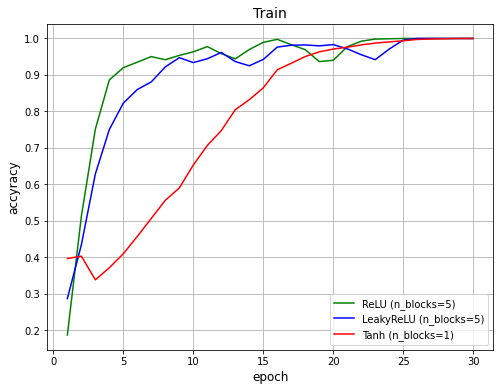

In [33]:
plot([historyRelu['acc'], historyLRelu['acc'], historyTanh['acc']],
     x='epoch', y='accyracy', title='Train',
     labels=['ReLU (n_blocks=5)', 'LeakyReLU (n_blocks=5)', 'Tanh (n_blocks=1)'],
     size=(8,6))

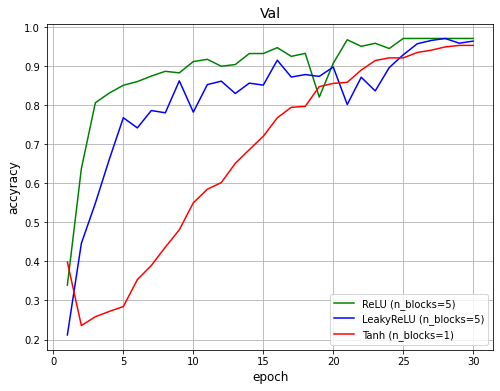

In [34]:
plot([historyRelu['v_acc'], historyLRelu['v_acc'], historyTanh['v_acc']],
     x='epoch', y='accyracy', title='Val',
     labels=['ReLU (n_blocks=5)', 'LeakyReLU (n_blocks=5)', 'Tanh (n_blocks=1)'],
     size=(8,6))